In [1]:
# pytorch 框架名称
# torch 顶层python包
# torch.nn 神经网络的模块
# torch.nn.init 模块下的子模块,用来初始化函数,不可实例化,用来组织代码
# torch.Linear 类，需要实例化,用来生成对象
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [2]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
# Sequence是torch的容器
# 用来把多个层串联起来组成网络 Sequence(A,B,C): A -> B -> C
# Flatten用来展平成1维的
# X:(batch, 1, 28, 28) -> (batch, 784)
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10)) 

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.01) # nn.init.normal_(tensor, mean=0.0, std=1.0)
# normal_表示原地赋值 in-place

net.apply(init_weights); # apply 会依次作用于Sequence的每一层, 而我只想init线性层

In [3]:
# 在前面 3.6节的例子中， 我们计算了模型的输出，然后将此输出送入交叉熵损失。
# 从数学上讲，这是一件完全合理的事情。 然而，从计算角度来看，指数可能会造成数值稳定性问题
# 比如如果有一个在softmax之前的预测值非常大,以至于exp上溢
# 解决这个问题的一个技巧是： 在继续softmax计算之前，先从所有ok中减去max(ok)
# 但是万一减去之后产生了下溢，怎么办
# 通过数学公式,不再计算y,而是计算log（y）

loss = nn.CrossEntropyLoss(reduction = 'none') #reduction表示数据处理方式,none->(batchsize,)/mean/sum

In [4]:
# 我们使用学习率为0.1的小批量随机梯度下降作为优化算法。 这与我们在线性回归例子中的相同，这说明了优化器的普适性

trainer = torch.optim.SGD(net.parameters(), lr = 0.1) # net.parameters自动读取所有可以更新的参数

In [ ]:
# 下面的内容和从零开始一样

In [12]:
def evaluate_accuracy(net, data_iter):  #@save
    if isinstance(net, torch.nn.Module): # isinstance来自 Python 本身，用来判断某个对象是不是某个类的实例
        net.eval() # 将模型设置为评估模式,因为只有module中才有eval所以要检查isinstance
    metric = Accumulator(2) # 正确预测数/预测总数
    with torch.no_grad(): # 关闭梯度
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # y.numel返回张量中元素的中的数量
    return metric[0] / metric[1]

In [10]:
def accuracy(y_hat, y): #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 比如 [0.1,0.8],[0.8,0.4] 我axis=1,把(2,2)->(2,1)
        # 也就是变成了[1][0]
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # 比较预测与真实标签是否相等,需要转化为相同type
    return float(cmp.type(y.dtype).sum())   

In [8]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        # 优雅的写法，data是目前自己的值，args表示可以接受任意类型的参数，zip打包表示一一对应。
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward() # 对 batchloss求均值可以防止batch越大,loss越大
            updater.step()
        else: 
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0]) # shape are like: [64,1,28,28]
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [6]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

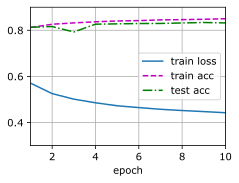

In [13]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)